Created by FedericaBBianco @fedhere for DSPS/MLNPS

Amended by Connor Mooney @comooney711, Ben Flaggs @bflaggs, Andrew Crossman @crossman, Nik Korzoun @nkorzounUD
# Kolmogorov Smirnoff test, application to earthquake data

In [ ]:
#all the imports I needed
from __future__ import print_function, division
import pandas as pd
import pylab as pl
import scipy as sp
import numpy as np #for table
from scipy import stats
%pylab inline
pl.style.use("https://raw.githubusercontent.com/fedhere/DSPS/master/fbb.mplstyle")

Populating the interactive namespace from numpy and matplotlib


This homework asks you to reproduce the work in [Corral 2018](https://arxiv.org/pdf/0910.0055.pdf) which is well described, but not "reproducible". 
Corral 2018 uses a K-S test to show that at different magnitude scales the time gaps between earthquakes follows the same distribution. If true, this indicates that there is a consistent scaling law. 

The argument is a little convoluted, but it is a somewhat innovative use of the test. Corall compares the time gap between earthquakes  greater than a certain magnitude threshold with the time gaps between earthquakes above a different threshold, and finds no differences.

Remind yourself exactly what the K-S test is about :

    1 What is the test's Null Hypothsis that the K-S test tests?
    
    


*The null hypothesis is that data sets from different stationary periods follow the same distribution.*



    2 What is the "statistic" or "pivotal quantity" that the test uses?
    


*The absolute value of the maximum distance between the cumulative distributions for each of the two data sets.*




    3 What does the probability distribution of this statistic depend on? 
    
   


*The distribution depends on the inter-event time above a size threshold s.*

    

# Data Retrival

The first reason why the paper is not techincally _reproducible_ is that, while a link is provided to retrieve the data, the link is dead. This happens often. Services like [Zenodo](https://zenodo.org/) or journals that serve data provide some insurance against this but unfortunately the standards are not strict. 

You can retrieve the data yourself from [this website](http://service.scedc.caltech.edu/eq-catalogs/poly.php). Think about what setting up data like this means for reproducibility. Did the author comply to reproducibility standards?__ Make sure the number of entries in your final dataset is similar to that of the authors. I got 70798, instead of 77000. 10% off, which I deem close enough. You should get something similar. Use the map in the paper to determine the region of interest. Call the file earthquakes_\<firstinitialLastname\>.csv and upload it to your github repository. Read it your file, instead of mine as instructed below. If you are getting weird results compare to what I got, go back and check how the files differ.

# Data Ingestion

## read in data

I saved the data in a file called "earthquakes.csv", where ```csv``` stands for "comma separated file". [This file format](https://www.howtogeek.com/348960/what-is-a-csv-file-and-how-do-i-open-it/) requires different entries in a row to be separated by commas alone (no space) and for commas to be used in quote if they are not intended to separate entries. 

```
a,b,c
d,e,f
g,"h,2",i
```
The data is uploaded on the  github homework repository but to read it in you will need to get the link to the *raw file*: the link to the file earthquakes.csv which is in my GitHub repository https://github.com/fedhere/MLPNS2021/tree/main/HW2_NHRT takes you to an ```html``` page that includes the content of the file, but you want to isolate the content of the file itself: the _raw file_. Pay attention to this: from the next time I will not give you the exact link, I will just point you to the file and you will have to find the link to the raw data from there. (remember to use the "raw" link)

The data can be read effectively using the _pandas_ python package as ```pandas.read_csv(<file name or URL>)```. 

However, I did not format the data correctly, according to the csv extension requirement. This happens all the time. Look at the file and use the pandas documentation to figure out how to read it with ```pd.read_csv()```

In [ ]:
eqdata = pd.read_csv("https://raw.githubusercontent.com/comooney711/"
                    + "DSPS_CMooney/main/HW3/earthquakes_BFlaggs.csv", sep=" ")

running the following lines of code should give you the same result as mine if you used the file I provided (467 students), and qualitatively  similar if you are using your own data (667 students)

In [ ]:
eqdata.shape

(67543, 34)

In [ ]:
eqdata.head()

,#YYY/MM/DD,HH:mm:SS.ss,ET,GT,MAG,Unnamed: 5,M,Unnamed: 7,Unnamed: 8,Unnamed: 9,LAT,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,LON,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,DEPTH,Q,Unnamed: 25,EVID,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,NPH,NGRM
0,1984/01/01,01:30:57.52,eq,NaN,l,2.02,c,NaN,NaN,33.246,-116.433,NaN,NaN,1.6,C,NaN,NaN,NaN,28255.0,NaN,NaN,13.0,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1984/01/01,05:31:34.16,eq,NaN,l,2.12,c,NaN,NaN,32.945,-116.295,NaN,NaN,5.4,C,NaN,NaN,NaN,28259.0,NaN,NaN,18.0,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1984/01/01,06:59:05.14,eq,NaN,l,2.43,c,NaN,NaN,33.343,-117.628,NaN,NaN,5.6,C,NaN,NaN,NaN,28260.0,NaN,NaN,13.0,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1984/01/01,11:10:25.29,eq,NaN,l,2.07,c,NaN,NaN,33.668,-116.780,NaN,13.8,C,NaN,NaN,NaN,28270.0,NaN,NaN,19.0,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1984/01/01,13:50:47.62,eq,NaN,l,2.25,c,NaN,NaN,35.944,-118.322,NaN,-1.4,C,NaN,NaN,NaN,28546.0,NaN,NaN,29.0,NaN,NaN,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
eqdata.tail()

,#YYY/MM/DD,HH:mm:SS.ss,ET,GT,MAG,Unnamed: 5,M,Unnamed: 7,Unnamed: 8,Unnamed: 9,LAT,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,LON,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,DEPTH,Q,Unnamed: 25,EVID,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,NPH,NGRM
67538,2002/12/30,21:51:52.55,eq,NaN,l,2.31,l,NaN,NaN,35.31867,-118.66250,NaN,NaN,1.5,A,NaN,9875017.0,NaN,NaN,66.0,NaN,404.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67539,2002/12/30,23:38:49.79,eq,NaN,l,2.05,l,NaN,NaN,35.31450,-118.66333,NaN,NaN,1.9,A,NaN,9875061.0,NaN,NaN,54.0,NaN,283.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67540,2002/12/31,05:51:00.05,eq,NaN,l,2.36,l,NaN,NaN,35.32367,-118.66067,NaN,NaN,0.1,A,NaN,9875093.0,NaN,NaN,65.0,NaN,465.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67541,2002/12/31,06:15:19.97,eq,NaN,l,2.15,l,NaN,NaN,34.00350,-116.39317,NaN,10.3,A,NaN,9875101.0,NaN,NaN,91.0,NaN,572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67542,2002/12/31,21:59:58.92,eq,NaN,l,2.18,l,NaN,NaN,33.18617,-115.61100,NaN,NaN,1.7,A,NaN,9875225.0,NaN,NaN,39.0,NaN,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


now that you have a dataframe object you can use methods of the object to modify it. Use the method ```eqdata.rename``` to change the names of the 3 columns that are the only three relevant to us: _date, time, magnitude_

## prepare date-time column

In [ ]:
eqdata = eqdata[['#YYY/MM/DD', 'HH:mm:SS.ss', 'Unnamed: 5']].rename(
            {'#YYY/MM/DD':"date", 'HH:mm:SS.ss':"time", 'Unnamed: 5':"mag"},
             axis=1)

In [ ]:
eqdata.head()

,date,time,mag
0,1984/01/01,01:30:57.52,2.02
1,1984/01/01,05:31:34.16,2.12
2,1984/01/01,06:59:05.14,2.43
3,1984/01/01,11:10:25.29,2.07
4,1984/01/01,13:50:47.62,2.25


In [ ]:
eqdata.describe()

,mag
count,67543.000000
mean,2.407589
std,0.404980
min,2.000000
25%,2.120000
50%,2.290000
75%,2.570000
max,7.300000


Now you want to combine the columns containing date and time and convert them to a "datetime" kind of data object. 


What data type are the _time_ and _date_ columns right now? What type you want them to be to conver them to datetime with ```pd.datetime()```? type 'O' means object, typically a string. 

In [ ]:
eqdata.time.dtype, eqdata.date.dtype

(dtype('O'), dtype('O'))

to do this conversion I 

   1. joined date and time into a single string for each row with a ["list comprehension"](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python) (essentially a for loop but more efficient and compact). You do not have to do it with a list comprehension, you can use just a for loop.

   2. used pd.datetime() to convert the resulting new dataframe column into a dataframe column containing _datetime_ objects (see lab)

   3. but this did not work because of the formatting of some dates, so I had to go back and fix 5 entries. (you are on your own to figure out this one)

In [ ]:
eqdata["datetime"] = [eqdata.iloc[i].date + " " + eqdata.iloc[i].time
                      for i in range(eqdata.shape[0])]

In [ ]:
# Error occors if we don't use this line because there are errors within the 
# date file itself that denote time as 60 seconds instead of either 0sec of 
# the next minute or 59.99 of the current minute
eqdata["datetime"] = eqdata["datetime"].str.replace("60.00","59.99")

# For some reason there was one data point with a time in seconds of 60.99
eqdata["datetime"] = eqdata["datetime"].str.replace("24:60.99","25:00.99")

In [ ]:
eqdata.head()

,date,time,mag,datetime
0,1984/01/01,01:30:57.52,2.02,1984/01/01 01:30:57.52
1,1984/01/01,05:31:34.16,2.12,1984/01/01 05:31:34.16
2,1984/01/01,06:59:05.14,2.43,1984/01/01 06:59:05.14
3,1984/01/01,11:10:25.29,2.07,1984/01/01 11:10:25.29
4,1984/01/01,13:50:47.62,2.25,1984/01/01 13:50:47.62


In [ ]:
# Check the data type of each column
eqdata.date.dtype, eqdata.time.dtype, eqdata.mag.dtype, eqdata.datetime.dtype

(dtype('O'), dtype('O'), dtype('float64'), dtype('O'))

In [ ]:
# Convers the datetime column of strings to the pandas datetime object
eqdata["datetime"] = pd.to_datetime(eqdata["datetime"])

In [ ]:
eqdata.datetime.dtype

dtype('<M8[ns]')

## select valuable data

Following the description in Section 2  of Corral 2018 I removed all data that did not belong to a "stationary" period. Third paragraph section 2 of Corral 2018. You can see the cell of code I used to do this [here](https://github.com/fedhere/DSPS/blob/master/HW3/Corral2018_selectStationary.py) at no points cost, cause it was a bit tricky, but I encourage you to try and do it yourself. If you can do it in fewer lines than I did its automatically +5 points (just turning the loop into a list comprehension does not count. That is an obvious way to decrease the number of lines of code; I did not do it simply to enhance readability.)

In [ ]:
# create empty container
ss = []

tstart = [1984, 1990.3, 1994.6, 1996.1, 1997, 1997.75, 1998.25, 2000.55,
          2000.9, 2001.6, 2002.5]
tstop = [1986.5, 1992.1, 1995.6, 1996.5, 1997.6, 1998.15, 1999.35, 2000.8,
         2001.25, 2002, 2003]

# loop through all year pairs as year and fraction of year
for i in range(len(tstart)):
    # for each pair I convert the year to datetime (easy)
    # then I convert the fraction of year and convert it to days and convert 
    # that to a delta-time
    # finally I add that deltatime to the year datetime. 
    ss.append((pd.to_datetime(int(tstart[i]), format="%Y") 
        + pd.Timedelta('%.f days'%((tstart[i] - int(tstart[i])) * 365.25)),
               pd.to_datetime(int(tstop[i]), format="%Y") 
        + pd.Timedelta('%.f days'%((tstop[i] - int(tstop[i])) * 365.25))))



In [ ]:
print ("the {} timestamp pairs that are the boundaries of good data periods"
       + "are:".format(len(ss)))

ss

the {} timestamp pairs that are the boundaries of good data periodsare:


[(Timestamp('1984-01-01 00:00:00'), Timestamp('1986-07-03 00:00:00')),
 (Timestamp('1990-04-21 00:00:00'), Timestamp('1992-02-07 00:00:00')),
 (Timestamp('1994-08-08 00:00:00'), Timestamp('1995-08-08 00:00:00')),
 (Timestamp('1996-02-07 00:00:00'), Timestamp('1996-07-02 00:00:00')),
 (Timestamp('1997-01-01 00:00:00'), Timestamp('1997-08-08 00:00:00')),
 (Timestamp('1997-10-02 00:00:00'), Timestamp('1998-02-25 00:00:00')),
 (Timestamp('1998-04-02 00:00:00'), Timestamp('1999-05-09 00:00:00')),
 (Timestamp('2000-07-20 00:00:00'), Timestamp('2000-10-19 00:00:00')),
 (Timestamp('2000-11-25 00:00:00'), Timestamp('2001-04-02 00:00:00')),
 (Timestamp('2001-08-08 00:00:00'), Timestamp('2002-01-01 00:00:00')),
 (Timestamp('2002-07-03 00:00:00'), Timestamp('2003-01-01 00:00:00'))]

In [ ]:
# boolean loop that finds all of the dates between ss[0][0] and ss[0][1]
(eqdata.datetime >= ss[0][0]) & (eqdata.datetime <= ss[0][1])

0         True
1         True
2         True
3         True
4         True
         ...  
67538    False
67539    False
67540    False
67541    False
67542    False
Name: datetime, Length: 67543, dtype: bool

The following cell of code shows you the array of bool values (True/False) which I create to use as an index to the input array: when used as an index, a technique called "broadcasting" in python, will select only elements of the original array where the index array value is True. something like 
Try:



In [ ]:
# make two arrays of the same length, one with booleans the other with data
# comma separate the two and only the data corresponding to the same index
# as true in the boolean array will remain
a = np.array([0, 1, 2])
a, a[[True, False, True]]


(array([0, 1, 2]), array([0, 2]))

For each of the 11 valid periods I create a condition 
``` datetime >= period_start AND datetime <= period_end ``` where AND is a product of booleans: True * False = False.

I want to take all chinks of data that satisfy this condition for any of the 11 chunks of time so that is a logical OR operator, or a sum of Booleans: True + False = True 

This is because ```True``` really corresponds to "not 0" and False to "0". So ```"not 0" * 0 = 0``` and ```"not 0" + 0 = not 0```
    

In [ ]:
gooddates =( ((eqdata.datetime >= ss[0][0]) & (eqdata.datetime <= ss[0][1])) |\
        # data between start and end of second time period
        ((eqdata.datetime >=ss [1][0]) & (eqdata.datetime <= ss[1][1])) |\
        ((eqdata.datetime >=ss [2][0]) & (eqdata.datetime <= ss[2][1])) |\
        ((eqdata.datetime >=ss [3][0]) & (eqdata.datetime <= ss[3][1])) |\
        ((eqdata.datetime >=ss [4][0]) & (eqdata.datetime <= ss[4][1])) |\
        ((eqdata.datetime >=ss [5][0]) & (eqdata.datetime <= ss[5][1])) |\
        ((eqdata.datetime >=ss [6][0]) & (eqdata.datetime <= ss[6][1])) |\
        ((eqdata.datetime >=ss [7][0]) & (eqdata.datetime <= ss[7][1])) |\
        ((eqdata.datetime >=ss [8][0]) & (eqdata.datetime <= ss[8][1])) |\
        ((eqdata.datetime >=ss [9][0]) & (eqdata.datetime <= ss[9][1])) |\
        # data between start and end of last time period
        ((eqdata.datetime >=ss [10][0]) & (eqdata.datetime <= ss[10][1])\
        ).values )

In [ ]:
print ( "there are {} earthquakes falling in the selected stationary periods".
       format(gooddates.sum()) )

there are 15182 earthquakes falling in the selected stationary periods


In [ ]:
eqdata = eqdata[gooddates]
eqdata.describe()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,mag
count,15182.000000
mean,2.362527
std,0.372127
min,2.000000
25%,2.100000
50%,2.250000
75%,2.500000
max,5.800000


Now what you really want is the _time interval between earthquakes_ for all events greater than some magnitude m, while all you have are the date and time of the events.: 

You can remove earthquakes smaller than magnitude 2 by, again, broadcasting. How would that look like?

In [ ]:
tempdata = eqdata[ eqdata.mag >= 2 ]
tempdata.describe()


,mag
count,15182.000000
mean,2.362527
std,0.372127
min,2.000000
25%,2.100000
50%,2.250000
75%,2.500000
max,5.800000


You can get the time between consecutive earthquakes with the method ```diff()``` of numpy arrays (in a pandas series you can get the data as a numpy array with the attribute .values: ```seried.values```). 


In [ ]:
eqdata["tgaps"] = eqdata.datetime.diff()

In [ ]:
eqdata.shape

(15182, 5)

In [ ]:
eqdata.head()

,date,time,mag,datetime,tgaps
0,1984/01/01,01:30:57.52,2.02,1984-01-01 01:30:57.520,NaT
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,0 days 04:00:36.640000
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,0 days 01:27:30.980000
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,0 days 04:11:20.150000
4,1984/01/01,13:50:47.62,2.25,1984-01-01 13:50:47.620,0 days 02:40:22.330000


In [ ]:
eqdata.describe()

,mag,tgaps
count,15182.000000,15181
mean,2.362527,0 days 10:58:16.959449311
std,0.372127,14 days 05:43:53.070440070
min,2.000000,0 days 00:00:00.170000
25%,2.100000,0 days 00:54:00.770000
50%,2.250000,0 days 03:04:41.570000
75%,2.500000,0 days 07:20:20.650000
max,5.800000,1388 days 11:06:10.750000


Note that the first entry will be NaT which is Not a Time (corresponding to nan for numerical variables) or maybe a negative number (depends on your exact operations above). You should remove it

In [ ]:
eqGoodData = eqdata.iloc[1:]

In [ ]:
# Convert the tgaps data to nanoseconds with a data type of float
eqGoodData["tgaps"] = ( eqGoodData["tgaps"].dt.total_seconds() ) * (10**9)

NameError: ignored

# data exploration
At this point you should wonder if this is the final dataset that you want to use and if anything is weird or suspicious about it. Visualize the distribution. A good way to visualize distributions is a histogram which you can prodice with pl.hist() or as a method of your dataframe series as ```df[SeriesName].plot(kind="hist")```. Produce a plot like the one below (label the axis! and describe it with a caption!). To get the logarithmic y axis you can se ```logy=True```, for example. in your ```df[SeriesName].plot``` call.

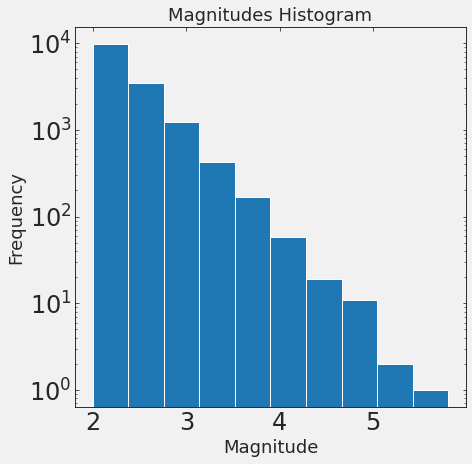

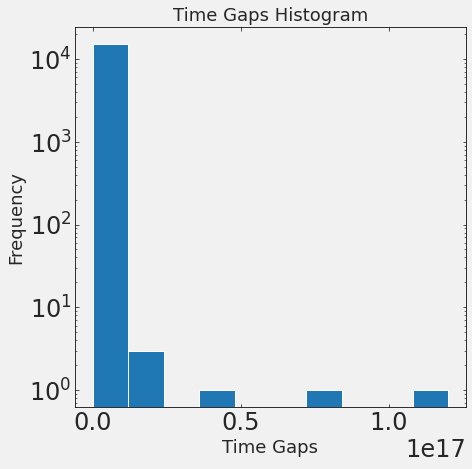

In [ ]:
ax1 = eqGoodData["mag"].plot(kind="hist", figsize=(7, 7), logy=True);
ax1.set_xlabel("Magnitude", fontsize=18);
ax1.set_ylabel("Frequency", fontsize=18);
ax1.set_title("Magnitudes Histogram", fontsize=18);
pl.show()

ax2 = eqGoodData["tgaps"].plot(kind="hist", figsize=(7, 7), logy=True);
ax2.set_xlabel("Time Gaps", fontsize=18);
ax2.set_ylabel("Frequency", fontsize=18);
ax2.set_title("Time Gaps Histogram", fontsize=18);
pl.show()

The thing that worries me is that by removing some sections of the data to use only stationary periods we created some artificially large gaps: gaps of order ~month. How many nanoseconds in a month? remove all gaps that are larger than about a month and see how the distribution looks (make another histogram).

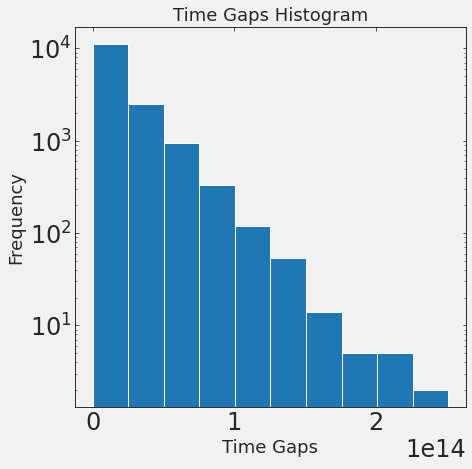

In [ ]:
eqGoodData =  eqGoodData[eqGoodData["tgaps"] < 2.6297E+15]
eqGoodData.describe()

ax3 = eqGoodData["tgaps"].plot(kind="hist", figsize=(7, 7), logy=True);
ax3.set_xlabel("Time Gaps", fontsize=18);
ax3.set_ylabel("Frequency", fontsize=18);
ax3.set_title("Time Gaps Histogram", fontsize=18);
pl.show()

# data analysis

### important: the paper does not do it but I want you to formally choose a threshold before you do this test. Choose a p-value (=$\alpha$ thresold: call your variable ```alpha```) of 3-$\sigma$.

Follow the instructions (algorithm) in **Section 3 paragraph 3** and compare your results with the results in table 1 with a threshold  of = 0.01 and 0.001

Do it for all 5 magnitude thresholds as indicated in the paper (and in Table 1).

Note that the x axis in plot Fig 1 is in _log space_. Use ```np.log10()``` to take the logarithm of the time gaps.

The pseudocode for the algorithm is [here](https://github.com/fedhere/DSPS/blob/master/HW3/Corral2018_pseudocode.md).


Reproduce the paper Fig 1 and Table 1. In the Table report the size of each dataset after cleaning the value of the statistic and the p-value, as done in Corral 2018. Use the scipy function for the 2 sample KS test. (resources [here](https://colab.research.google.com/notebooks/markdown_guide.ipynb#scrollTo=70pYkR9LiOV0) to learn about the table syntax in markdown)

In [ ]:
'''
For threshold 0.01 and 0.001:
  	For all Mk values of M in Corral2018:
		{
		# remove gaps below minimum gap threshold
		x_Mk =  gaps where M > M_k
		For i in [1,2]: # do it twice
			{
			# Rescale the time gaps distribution by the mean value of the time gaps.
			Rk = 1 / mean of x_Mk
			X_Mk = x_Mk * Rk where x_Mk*Rk  > threshold # can be achieved broadcasting in python
			}
		# these two lines of code are not necessary cause Rk~1
		Rk = 1 / mean of x_Mk
		x_Mk = x_Mk * Rk
		
	For all Mk values of M in Corral2018:
		{
   		For all Ml values of M in Corral2018 greater than Mk
			{
			Perform the KS test on (Mk, Ml)
			}
   		}

'''


'\nFor threshold 0.01 and 0.001:\n  \tFor all Mk values of M in Corral2018:\n\t\t{\n\t\t# remove gaps below minimum gap threshold\n\t\tx_Mk =  gaps where M > M_k\n\t\tFor i in [1,2]: # do it twice\n\t\t\t{\n\t\t\t# Rescale the time gaps distribution by the mean value of the time gaps.\n\t\t\tRk = 1 / mean of x_Mk\n\t\t\tX_Mk = x_Mk * Rk where x_Mk*Rk  > threshold # can be achieved broadcasting in python\n\t\t\t}\n\t\t# these two lines of code are not necessary cause Rk~1\n\t\tRk = 1 / mean of x_Mk\n\t\tx_Mk = x_Mk * Rk\n\t\t\n\tFor all Mk values of M in Corral2018:\n\t\t{\n   \t\tFor all Ml values of M in Corral2018 greater than Mk\n\t\t\t{\n\t\t\tPerform the KS test on (Mk, Ml)\n\t\t\t}\n   \t\t}\n\n'

In [ ]:
# Try to implement the pseudocode into working code
Mk_vals = [2.0, 2.5, 3.0, 3.5, 4.0]
Ml_vals = [2.5, 3.0, 3.5, 4.0]
threshold = [0.01, 0.001]

stats = []
pvals= []

for t in threshold:
  for Mk in Mk_vals:
    for Ml in Ml_vals:
      x_Mk = eqGoodData[eqGoodData["mag"] > Mk]["tgaps"]
      x_Ml = eqGoodData[eqGoodData["mag"] > Ml]["tgaps"]
      for i in range(2): # do it twice
        Rk = 1 / x_Mk.mean()
        Rl = 1 / x_Ml.mean()
        temp1 = x_Mk * Rk
        temp2 = x_Ml * Rl
        x_Mk = temp1[(temp1 > t)]
        x_Ml = temp2[(temp2 > t)]
        
      if Ml > Mk:
        # Run KD test on (Mk_vals[Mk], Mk_vals[Ml])        
        print(f"Running KS test on mag values ({Mk}, {Ml}) for threshold={t}.")
        statistic, pvalue = sp.stats.ks_2samp(x_Mk, x_Ml)
        stats.append(statistic)
        pvals.append(pvalue)
        print(f"KS statistic: {statistic}, p value: {pvalue}.")

      else:
        continue

Running KS test on mag values (2.0, 2.5) for threshold=0.01.
KS statistic: 0.014532321107332602, p value: 0.5977093748926117.
Running KS test on mag values (2.0, 3.0) for threshold=0.01.
KS statistic: 0.03355003092478559, p value: 0.2935324556340807.
Running KS test on mag values (2.0, 3.5) for threshold=0.01.
KS statistic: 0.08396403343424541, p value: 0.0680578768109664.
Running KS test on mag values (2.0, 4.0) for threshold=0.01.
KS statistic: 0.10904834494773519, p value: 0.4349168669606812.
Running KS test on mag values (2.5, 3.0) for threshold=0.01.
KS statistic: 0.027779301197786356, p value: 0.6225710000219049.
Running KS test on mag values (2.5, 3.5) for threshold=0.01.
KS statistic: 0.07854605441985585, p value: 0.11327996909050353.
Running KS test on mag values (2.5, 4.0) for threshold=0.01.
KS statistic: 0.10728451972555746, p value: 0.43379249500451944.
Running KS test on mag values (3.0, 3.5) for threshold=0.01.
KS statistic: 0.06524391345997434, p value: 0.36757137661018

In [ ]:
# make table
dim = 5
d1 = np.zeros((dim,dim))
d2 = np.zeros((dim,dim))

# fill table
for k in range(dim):
  for l in range(dim):
    if k < l:
      d1[k][l] = pvals[k+l-1]
      d2[k][l] = pvals[k+l+dim-1]
    elif k > l:
      d1[k][l] = stats[k+l-1]
      d2[k][l] = stats[k+l+dim-1]

df1 = pd.DataFrame(data=d1, columns=['M>=2.0','M>=2.5','M>=3.0','M>=3.5','M>=4.0'], index=['M>=2.0','M>=2.5','M>=3.0','M>=3.5','M>=4.0'])
df2 = pd.DataFrame(data=d2, columns=['M>=2.0','M>=2.5','M>=3.0','M>=3.5','M>=4.0'], index=['M>=2.0','M>=2.5','M>=3.0','M>=3.5','M>=4.0'])


In [ ]:
print(df1)

          M>=2.0    M>=2.5    M>=3.0    M>=3.5    M>=4.0
M>=2.0  0.000000  0.597709  0.293532  0.068058  0.434917
M>=2.5  0.014532  0.000000  0.068058  0.434917  0.622571
M>=3.0  0.033550  0.083964  0.000000  0.622571  0.113280
M>=3.5  0.083964  0.109048  0.027779  0.000000  0.433792
M>=4.0  0.109048  0.027779  0.078546  0.107285  0.000000


## Figure (**5**)
###p-value (top diagonal) and KS-statistic (bottom-diagonal) for rescaled earthquake magnitude time differences with threshold 0.01. Read the same way as in table 1 in (Corral 2018)

In [ ]:
print(df2)

          M>=2.0    M>=2.5    M>=3.0    M>=3.5    M>=4.0
M>=2.0  0.000000  0.113280  0.433792  0.367571  0.475519
M>=2.5  0.078546  0.000000  0.367571  0.475519  0.848016
M>=3.0  0.107285  0.065244  0.000000  0.848016  0.091982
M>=3.5  0.065244  0.106240  0.082480  0.000000  0.100439
M>=4.0  0.106240  0.082480  0.022845  0.040430  0.000000


## Figure (**6**)
### p-value (top diagonal) and KS-statistic (bottom-diagonal) for rescaled earthquake magnitude time differences with threshold 0.001. Read the same way as in table 1 in (Corral 2018)

Did you find any statistical significant differences between the distributions? What does it mean? Is your result identical to Correll's 2018? Why or why not? **Discuss!**

### "extra credits"

**How could you _force_ a significant result?**
Organize your result for different magnitude threshold in a numpy array (it should be a 5x5 array) for both cutoffs (0.01 and 0.001). Each of these arrays should contain the p-value for the pair of distributions i,j in cell \[i\]\[j\] and \[j\]\[i\]. Use ```imshow``` to visualize this 2D data. FIrst visualize the matrix itself as done below.

In [ ]:
# your code here
        
pl.imshow((ks_001));
pl.axis('off')
cb = pl.colorbar()
cb.ax.set_ylabel(r'$p$-value')
pl.title("KS test results");
#add a caption

NameError: ignored


Now visualize the result as a matrix where the cells are white if the results is not statistically significant and red otherwise. 
After doing it fot the set alpha threshold, lower your alpha threshold so that at least one pair of distribution has a statistically significant difference. **Warning!! this is an _unethical and horrifying practice_! Once you chose your significance threshold you are never allowed to change it! Why? Discuss**

Redoing it for threshold 0001